# Bayesian Bake-Off: Team MCMC

This is one of two notebooks that solve the same problem two ways: using a grid algorithm and using MCMC sampling.

The problem is based on Chapter 12 of [Probably Overthinking It](https://greenteapress.com/wp/probably-overthinking-it/) by Allen Downey.

**Note: If runnig on Colab, you will want to switch the runtime type to GPU!**

## Imports and Function Definitions

In [ ]:
%%capture
!pip install 'pymc==5.9.0' 'numpyro==0.13.2'

In [ ]:
from logging import getLogger

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import arviz as az

In [ ]:
getLogger("pymc").setLevel("INFO")

In [ ]:
az.style.use("arviz-whitegrid")
seed = sum(map(ord, "irt"))
rng = np.random.default_rng(seed)

## Read the Data

In [ ]:
from os.path import basename, exists
from pathlib import Path

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

In [ ]:
download("https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_pacs_resampled.hdf")

'gss_pacs_resampled.hdf'

The HDF file contains three resamplings of the GSS data, with the keys `gss0`, `gss1`, and `gss2`. The resampled data correct for stratified sampling in the GSS survey design, and provide a coarse estimate of variability due to random sampling. I do development and testing with one resampling, then check that the results are consistent with the others.

In [ ]:
gss = pd.read_hdf('gss_pacs_resampled.hdf', 'gss0')
gss.shape

(72390, 204)

In [ ]:
bins = np.arange(1889, 2011, 10)
labels = bins[:-1] + 1

gss['cohort10'] = pd.cut(gss['cohort'], bins, labels=labels).astype(float)

In [ ]:
gss.dropna(subset=['cohort10'], inplace=True)
gss['cohort10'] = gss['cohort10'].astype(int)

## Quantifying Political Beliefs

One of my goals in the chapter is to quantify liberal and conservative beliefs and see how they have changed over time, using data from the [General Social Survey](https://www.norc.org/Research/Projects/Pages/general-social-survey.aspx) (GSS).
So, how do we classify beliefs as conservative or liberal? And then, how do we track those beliefs over time?

To answer the first question, I started with a list of about 120 core GSS questions that ask about political beliefs, broadly defined.
For each question, I identified the responses that were chosen more often by people who consider themselves conservative.

Then, I searched for questions with the biggest differences between the responses of liberals and conservatives. From those, I curated a list of fifteen questions that cover a diverse set of topics, with preference for questions that were asked most frequently over the years of the survey.

The topics that made the list are not surprising. They include economic issues like public spending on welfare and the environment; policy issues like the legality of guns, drugs, and pornography; as well as questions related to sex education and prayer in schools, capital punishment, assisted suicide, and (of course) abortion. The list also includes three of the questions we looked at in previous sections, related to open housing laws, women in politics, and homosexuality.

For the current purpose, we are not concerned with the wording of the questions; we only need to know that liberals and conservatives give different answers. But if you are curious, I'll put the questions at the end of this post.

To classify respondents, I'll use responses to the following question:

> I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

The points on the scale are Extremely liberal, Liberal, and Slightly liberal; Moderate;	Slightly conservative, Conservative, and Extremely conservative.

I'll lump the first three points into "Liberal" and the last three into "Conservative", which makes the number of groups manageable and, it turns out, roughly equal in size.
Here's how many respondents are in each group.

In [ ]:
recode_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}
gss["polviews3"] = gss["polviews"].replace(recode_polviews)
gss["polviews3"].value_counts()

Moderate        23893
Conservative    21335
Liberal         17043
Name: polviews3, dtype: int64

Here are the variable names and the responses chosen more often by conservatives.
Most of the questions are binary, but some allow a range of responses.

In [ ]:
convervative_values = {
    "abany": [2],
    "homosex": [1, 2, 3],
    "premarsx": [1, 2, 3],
    "prayer": [2],
    "natfare": [3],
    "grass": [2],
    "natenvir": [2, 3],  # about right or too much
    "divlaw": [2],
    "cappun": [1],
    "racopen": [1],
    "letdie1": [2],
    "fepol": [1],
    "gunlaw": [2],
    "sexeduc": [2],
    "pornlaw": [1],
}

In [ ]:
order = [
    "homosex",
    "cappun",
    "grass",
    "abany",
    "prayer",
    "premarsx",
    "divlaw",
    "natfare",
    "natenvir",
    "pornlaw",
    "racopen",
    "letdie1",
    "fepol",
    "gunlaw",
    "sexeduc",
]

I'll extract the answers to the fifteen questions into a `DataFrame` of boolean values, `1` if the respondent chose a conservative response, `0` if they didn't and `NaN` if they were not asked the question or didn't answer.

In [ ]:
questions = pd.DataFrame(dtype=float)

for varname in order:
    questions[varname] = gss[varname].isin(convervative_values[varname]).astype(float)
    null = gss[varname].isna()
    questions.loc[null, varname] = np.nan
questions["year"] = gss["year"]

In [ ]:
questions

homosex  cappun  grass  abany  prayer  premarsx  divlaw  natfare  \
0          NaN     NaN    NaN    NaN     NaN       1.0     NaN      NaN   
1          NaN     NaN    NaN    NaN     NaN       1.0     NaN      NaN   
2          NaN     NaN    NaN    NaN     NaN       1.0     NaN      NaN   
3          NaN     NaN    NaN    NaN     NaN       1.0     NaN      NaN   
4          NaN     NaN    NaN    NaN     NaN       1.0     NaN      NaN   
...        ...     ...    ...    ...     ...       ...     ...      ...   
72385      0.0     1.0    0.0    1.0     NaN       NaN     NaN      NaN   
72386      NaN     1.0    NaN    NaN     NaN       0.0     NaN      1.0   
72387      1.0     1.0    0.0    1.0     NaN       NaN     NaN      NaN   
72388      NaN     1.0    1.0    NaN     0.0       1.0     NaN      0.0   
72389      NaN     1.0    0.0    NaN     1.0       0.0     NaN      NaN   

       natenvir  pornlaw  racopen  letdie1  fepol  gunlaw  sexeduc  year  
0           NaN      NaN      NaN      NaN    NaN     NaN      NaN  1972  
1           NaN      NaN      NaN      NaN    NaN     0.0      NaN  1972  
2           NaN      NaN      NaN      NaN    NaN     0.0      NaN  1972  
3           NaN      NaN      NaN      NaN    NaN     1.0      NaN  1972  
4           NaN      NaN      NaN      NaN    NaN     0.0      NaN  1972  
...         ...      ...      ...      ...    ...     ...      ...   ...  
72385       NaN      0.0      NaN      NaN    NaN     0.0      NaN  2022  
72386       0.0      0.0      NaN      0.0    NaN     NaN      0.0  2022  
72387       NaN      0.0      NaN      NaN    NaN     1.0      NaN  2022  
72388       1.0      1.0      NaN      0.0    0.0     NaN      0.0  2022  
72389       NaN      0.0      NaN      NaN    0.0     NaN      0.0  2022  

[71618 rows x 16 columns]

For each questions, here's the fraction of all respondents who chose a conservative response.

In [ ]:
questions.mean().sort_values()

sexeduc        0.123340
gunlaw         0.250037
fepol          0.282195
letdie1        0.314927
pornlaw        0.363665
racopen        0.375597
natenvir       0.379655
natfare        0.467340
divlaw         0.490939
premarsx       0.533950
abany          0.583890
prayer         0.589122
grass          0.677196
homosex        0.695584
cappun         0.700537
year        1997.549583
dtype: float64

Now let's group the respondents by political label and compute the percentage of conservative responses in each.

In [ ]:
augmented = pd.concat([questions, gss["polviews3"]], axis=1)
table = augmented.groupby("polviews3").mean().transpose() * 100
table[:-1]

polviews3  Conservative    Liberal   Moderate
homosex       80.092662  52.337900  69.696157
cappun        79.086744  56.185338  72.306497
grass         75.236948  53.986284  67.425543
abany         69.427806  41.452613  58.497102
prayer        66.719078  43.253610  61.895926
premarsx      64.186184  38.025460  51.221477
divlaw        58.510374  38.257774  48.055576
natfare       57.672645  33.460116  47.237803
natenvir      48.662821  25.057568  37.155963
pornlaw       43.918968  24.732184  35.467433
racopen       42.058961  27.613412  36.762226
letdie1       38.439965  23.696370  28.359148
fepol         32.729614  20.872513  27.501363
gunlaw        31.936266  18.122198  23.732719
sexeduc       18.406276   7.037597   9.610372

Here's a short text description for each question.

In [ ]:
issue_dict = {
    "abany": "Abortion",
    "homosex": "Homosexuality",
    "premarsx": "Premarital sex",
    "prayer": "School prayer",
    "natfare": "Welfare spending",
    "grass": "Legal cannabis",
    "natenvir": "Environment",
    "divlaw": "Divorce",
    "cappun": "Capital punishment",
    "racopen": "Fair housing law",
    "letdie1": "Assisted suicide",
    "fepol": "Women in politics",
    "gunlaw": "Gun law",
    "sexeduc": "Sex education",
    "pornlaw": "Pornography",
}

issue_names = pd.Series(issue_dict)[order].values

The following figure shows, for each question, the percentage of liberals, moderates, and conservatives who chose one of the conservative responses.

In [ ]:
polview_names = ["Conservative", "Moderate", "Liberal"]

muted = sns.color_palette("muted", 5)
polview_map = dict(zip(polview_names, [muted[3], muted[4], muted[0]]))
marker_map = dict(zip(polview_names, ["s", "^", "o"]))
line_map = dict(zip(polview_names, ["--", "-.", ":"]))

In [ ]:
table["Liberal"]

homosex         52.337900
cappun          56.185338
grass           53.986284
abany           41.452613
prayer          43.253610
premarsx        38.025460
divlaw          38.257774
natfare         33.460116
natenvir        25.057568
pornlaw         24.732184
racopen         27.613412
letdie1         23.696370
fepol           20.872513
gunlaw          18.122198
sexeduc          7.037597
year        199901.525553
Name: Liberal, dtype: float64

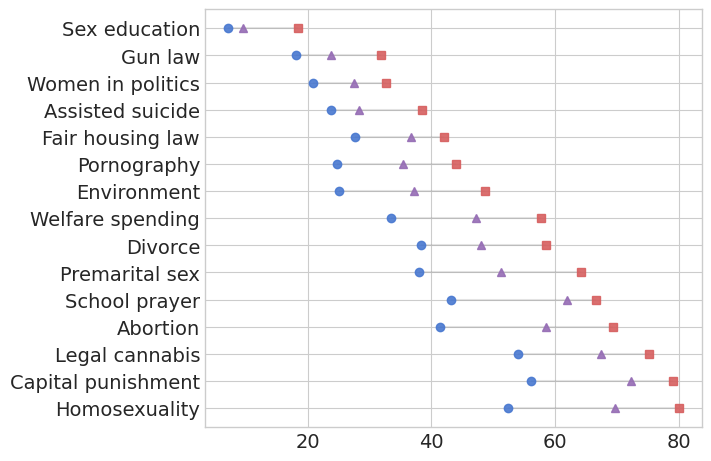

In [ ]:
plt.figure(figsize=(7, 4.5))
plt.hlines(
    issue_names,
    table["Liberal"][:-1],
    table["Conservative"][:-1],
    color="gray",
    alpha=0.2,
)

for polviews, color in polview_map.items():
    x = table[polviews][:-1]
    marker = marker_map[polviews]
    plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polviews)

Not surprisingly, conservatives are more likely than liberals to choose conservative responses, and moderates are somewhere in the middle.
The differences between the groups range from 11 to 27 percentage points.

In [ ]:
(table["Conservative"] - table["Liberal"]).sort_values()

year       -17.911773
sexeduc     11.368680
fepol       11.857101
gunlaw      13.814068
racopen     14.445549
letdie1     14.743595
pornlaw     19.186783
divlaw      20.252600
grass       21.250664
cappun      22.901406
prayer      23.465467
natenvir    23.605254
natfare     24.212529
premarsx    26.160724
homosex     27.754762
abany       27.975193
dtype: float64

These results include respondents over the interval from 1973 to 2021, so they are not a snapshot of recent conditions.
Rather, they show the issues that have distinguished conservatives from liberals over the last 50 years.

## Item Response Theory

Now that we've chosen questions that distinguish liberals and conservatives, the next step is to estimate the conservatism of each respondent.
If all respondents answered all of the questions, this would be relatively easy, but they didn't.

Some were surveyed before a particular question was added to the survey or after it was removed.
Also, in some years respondents were randomly assigned a "ballot" with subset of the questions.
Finally, a small percentage of respondents refuse to answer some questions, or say "I don't know".

The following figure shows the distribution of the number of questions answered.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


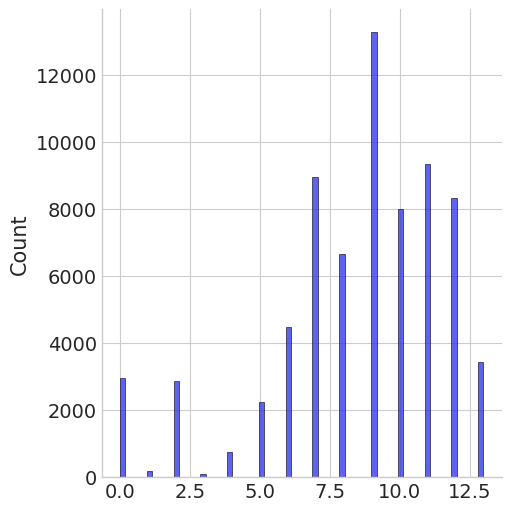

In [ ]:
sns.displot(questions.iloc[:, :-1].notna().sum(axis=1));

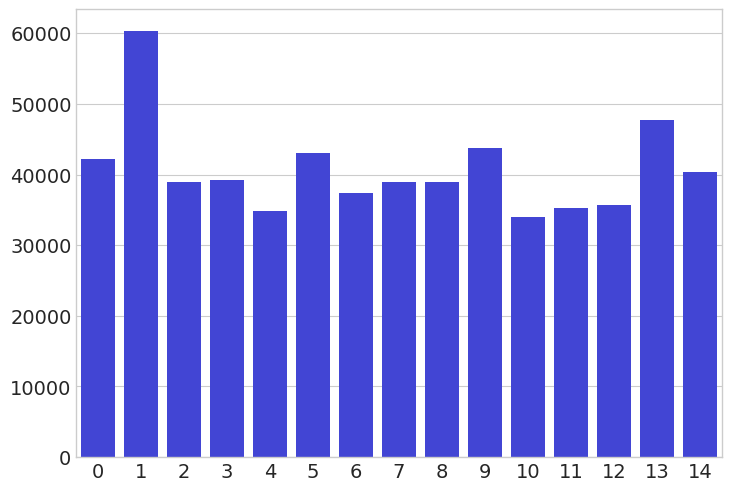

In [ ]:
sns.barplot(x=np.arange(15), y=questions.iloc[:, :-1].notna().sum(axis=0), color="C0");

Most respondents answered at least 5 questions, which is enough to get a sense of how conservative they are.
But there's another problem: some questions are "easier" than others.
For some questions a majority choose a conservative response; for others it's a small minority.
If two people answer a different subject of the questions, we can't compare them directly.

However, this is exactly the problem [item response theory](https://en.wikipedia.org/wiki/Item_response_theory) (IRT) is intended to solve!
The fundamental assumptions of IRT are:

* Each question has some level of difficulty, $d_j$.

* Each respondent has some level of efficacy, $e_i$.

* The probability that a respondent gets a question right is a function of $d_j$ and $e_i$.

In this context, a question is "difficult" if few people choose a conservative response and "easy" if many do.
And if a respondent has high "efficacy", that means they have a high tendency to choose conservative responses.

In one simple version of IRT, if a person with efficacy $e_i$ answers a question with difficulty $d_j$, the probability they get it right is

$$ \operatorname{expit}~(e_i - d_j)$$

Efficacy and difficulty are latent attributes; that is, we don't observe them directly. Rather, we infer them from data.
In some models, we use a large dataset to estimate $e$ for each respondent and $d$ for each question simultaneously.

In [ ]:
# Let's subsample 5k respondents

# Include the case that was shown in the grid approx
# And one case with a single answer
REF_IDs = (5034, 309)

ref_id_in_sample = False
while not ref_id_in_sample:
    subset = questions.sample(5_000, random_state=rng)
    idxs = subset.index.values
    ref_id_in_sample = REF_IDs[0] in idxs and REF_IDs[1] in idxs

q = subset.copy()
q["id"] = q.index
long_q = pd.melt(
    q,
    value_vars=q.columns[:-2],
    id_vars=["id"],
    var_name="question",
    value_name="answer",
).dropna().sort_values(by="id")
long_q.shape

(42398, 3)

In [ ]:
long_q = long_q.join(q["year"], on="id")
long_q

id  question  answer  year
66899      6    gunlaw     0.0  1972
26899      6  premarsx     1.0  1972
66006     12    gunlaw     0.0  1972
26006     12  premarsx     1.0  1972
26484     73  premarsx     0.0  1972
...      ...       ...     ...   ...
48327  72389   pornlaw     0.0  2022
28327  72389  premarsx     0.0  2022
23327  72389    prayer     1.0  2022
63327  72389     fepol     0.0  2022
73327  72389   sexeduc     0.0  2022

[42398 rows x 4 columns]

In [ ]:
q_cat = pd.Categorical(long_q["question"])
q_cat.categories, q_cat.codes

(Index(['abany', 'cappun', 'divlaw', 'fepol', 'grass', 'gunlaw', 'homosex',
        'letdie1', 'natenvir', 'natfare', 'pornlaw', 'prayer', 'premarsx',
        'racopen', 'sexeduc'],
       dtype='object'),
 array([ 5, 12,  5, ..., 11,  3, 14], dtype=int8))

In [ ]:
id_cat = pd.Categorical(long_q["id"])
id_cat.categories, id_cat.codes

(Int64Index([    6,    12,    73,    80,    91,   133,   178,   192,   195,
               218,
             ...
             72276, 72292, 72297, 72319, 72357, 72358, 72359, 72362, 72370,
             72389],
            dtype='int64', length=4768),
 array([   0,    0,    1, ..., 4767, 4767, 4767], dtype=int16))

## Unpooled model

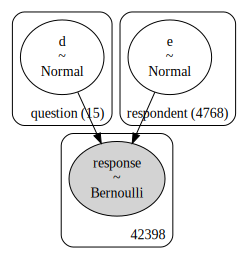

In [ ]:
coords = {
    "question": q_cat.categories,
    "respondent": id_cat.categories,
}
with pm.Model(coords=coords) as m1:
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))
    e = pm.Normal("e", mu=0, sigma=4, dims=("respondent",))

    logit_p = e[id_cat.codes] - d[q_cat.codes]

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        observed = long_q["answer"].values,
    )

pm.model_to_graphviz(m1)

In [ ]:
with m1:
    idata1 = pm.sample(nuts_sampler="numpyro", random_seed=rng)
    az.to_netcdf(idata1, "idata1.nc")

Compiling...


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:655: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:06.648751
Sampling...


sample: 100%|██████████| 2000/2000 [00:47<00:00, 41.88it/s, 31 steps of size 1.59e-01. acc. prob=0.86]


Sampling time =  0:02:10.461750
Transforming variables...
Transformation time =  0:00:00.616201


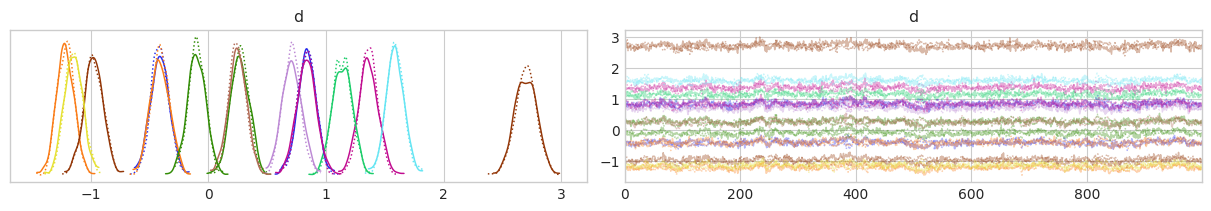

In [ ]:
az.plot_trace(idata1, var_names=["d"]);

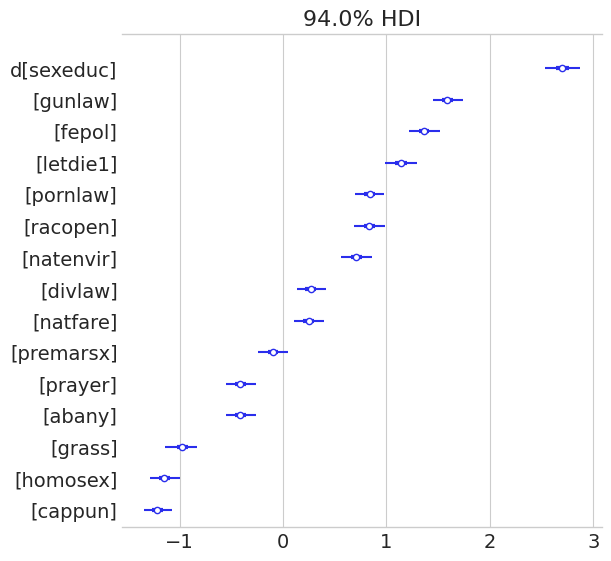

In [ ]:
d_means = idata1.posterior["d"].mean(("chain", "draw"))
sorted_q = idata1.posterior["question"].sortby(-d_means)
az.plot_forest(idata1, var_names=["d"], coords={"question": sorted_q}, combined=True);

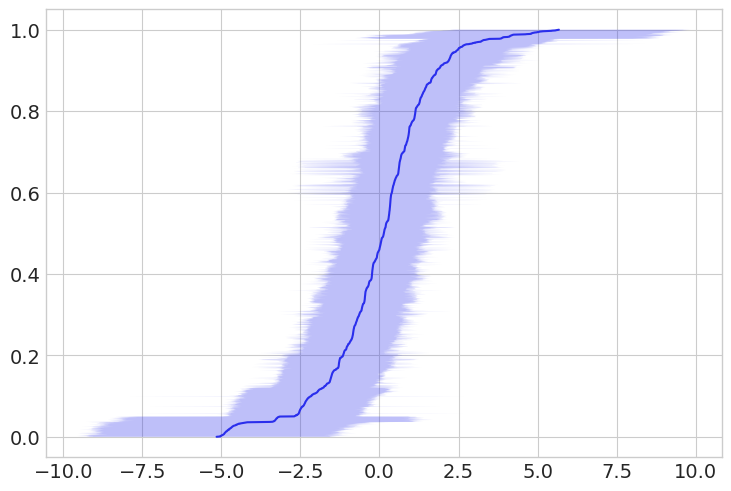

In [ ]:
mean_e = idata1.posterior["e"].mean(("chain", "draw"))
sorted_respondents = idata1.posterior["respondent"].sortby(mean_e)

y = np.linspace(0, 1, len(mean_e.respondent))
hdi = az.hdi(idata1.posterior["e"]).sortby(mean_e)
plt.plot(mean_e.sortby(mean_e), y)
plt.fill_betweenx(y, hdi["e"].values[:, 0], hdi["e"].values[:, 1], alpha=0.3);

### Posterior predictive

In [ ]:
with pm.Model(coords=coords):
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))
    e = pm.Normal("e", mu=0, sigma=4, dims=("respondent",))

    # Outer difference
    logit_p = e[:, None] - d

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        dims=("respondent", "question")
    )

    pm.Deterministic(
        "response_sum",
        response.sum(axis=-1),
        dims=("respondent"),
    )

    pp1 = pm.sample_posterior_predictive(
        idata1,
        var_names=["response_sum"],
        predictions=True,
        random_seed=rng,
    )

INFO:pymc.sampling.forward:Sampling: [response]


In [ ]:
pp1.predictions["response_sum"].mean()

<xarray.DataArray 'response_sum' ()>
array(6.78524035)

In [ ]:
idata1.posterior["e"].mean(("chain", "draw"))[:5]

<xarray.DataArray 'e' (respondent: 5)>
array([ 0.6334732 ,  0.61166939, -3.23870019,  0.60633208,  0.64508126])
Coordinates:
  * respondent  (respondent) int64 6 12 73 80 91

In [ ]:
pp1.predictions["response_sum"].mean(("chain", "draw"))[:5]

<xarray.DataArray 'response_sum' (respondent: 5)>
array([8.179 , 8.086 , 2.0165, 8.103 , 8.1715])
Coordinates:
  * respondent  (respondent) int64 6 12 73 80 91

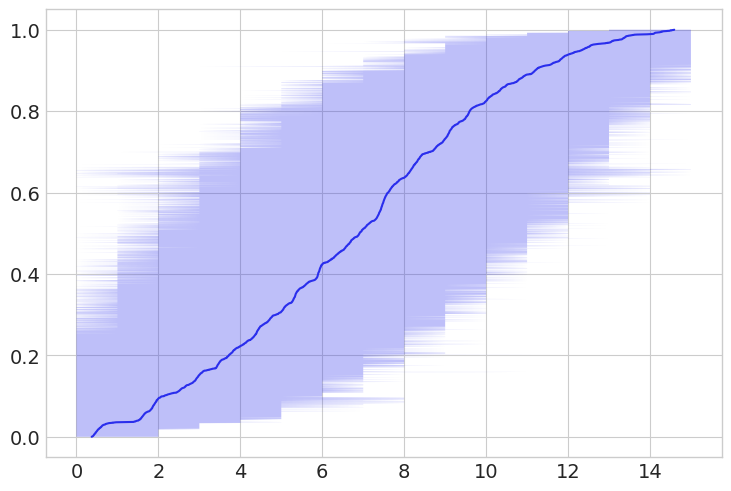

In [ ]:
mean_r = pp1.predictions["response_sum"].mean(("chain", "draw"))
sorted_respondents = idata1.posterior["respondent"].sortby(mean_e)

y = np.linspace(0, 1, len(mean_r.respondent))
hdi = az.hdi(pp1.predictions["response_sum"]).sortby(mean_r)
plt.plot(mean_r.sortby(mean_r), y)
plt.fill_betweenx(y, hdi["response_sum"].values[:, 0], hdi["response_sum"].values[:, 1], alpha=0.3);

### Single respondent

In [ ]:
long_q.query(f"id == {REF_IDs[0]}")

id  question  answer  year
54022  5034   racopen     1.0  1975
64022  5034     fepol     0.0  1975
69022  5034    gunlaw     1.0  1975
49022  5034   pornlaw     0.0  1975
74022  5034   sexeduc     0.0  1975
24022  5034    prayer     0.0  1975
39022  5034   natfare     0.0  1975
14022  5034     grass     0.0  1975
9022   5034    cappun     1.0  1975
34022  5034    divlaw     1.0  1975
44022  5034  natenvir     1.0  1975
29022  5034  premarsx     1.0  1975

In [ ]:
long_q.query(f"id == {REF_IDs[1]}")

id  question  answer  year
29077  309  premarsx     1.0  1972

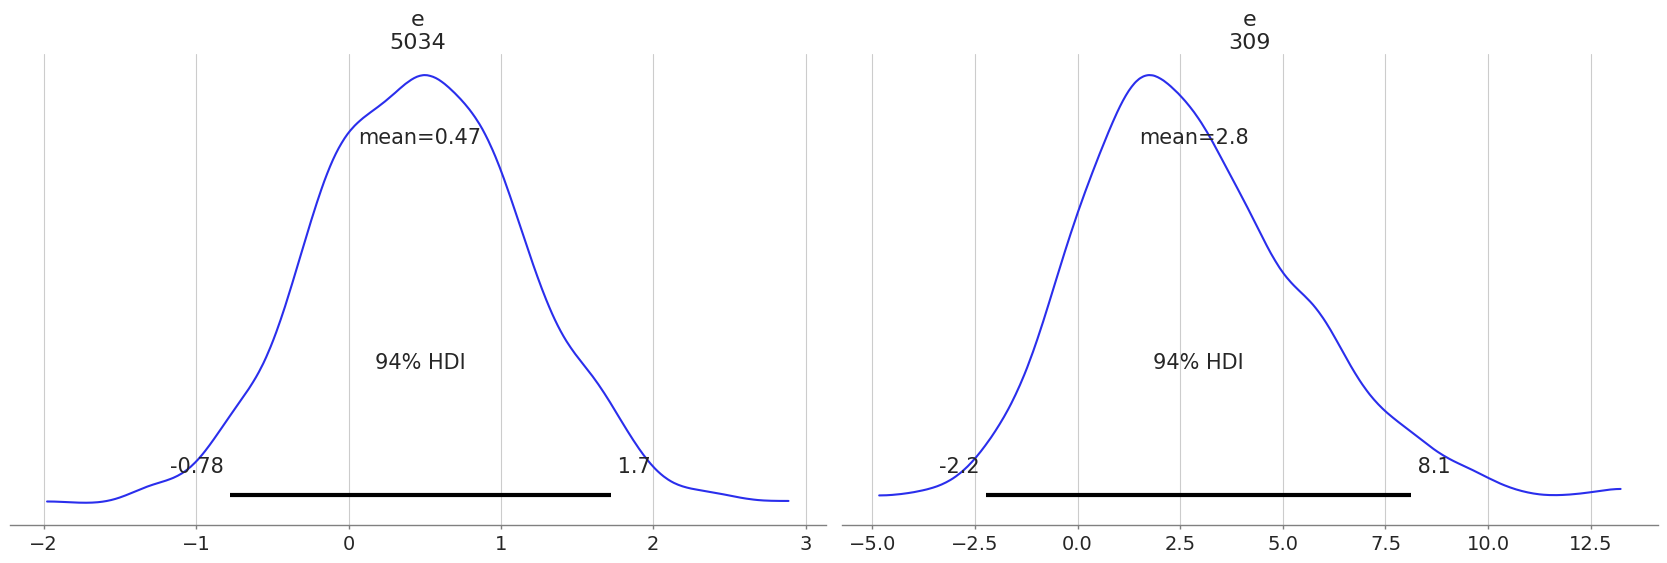

In [ ]:
az.plot_posterior(idata1.posterior.sel(respondent=list(REF_IDs)), var_names=["e"]);

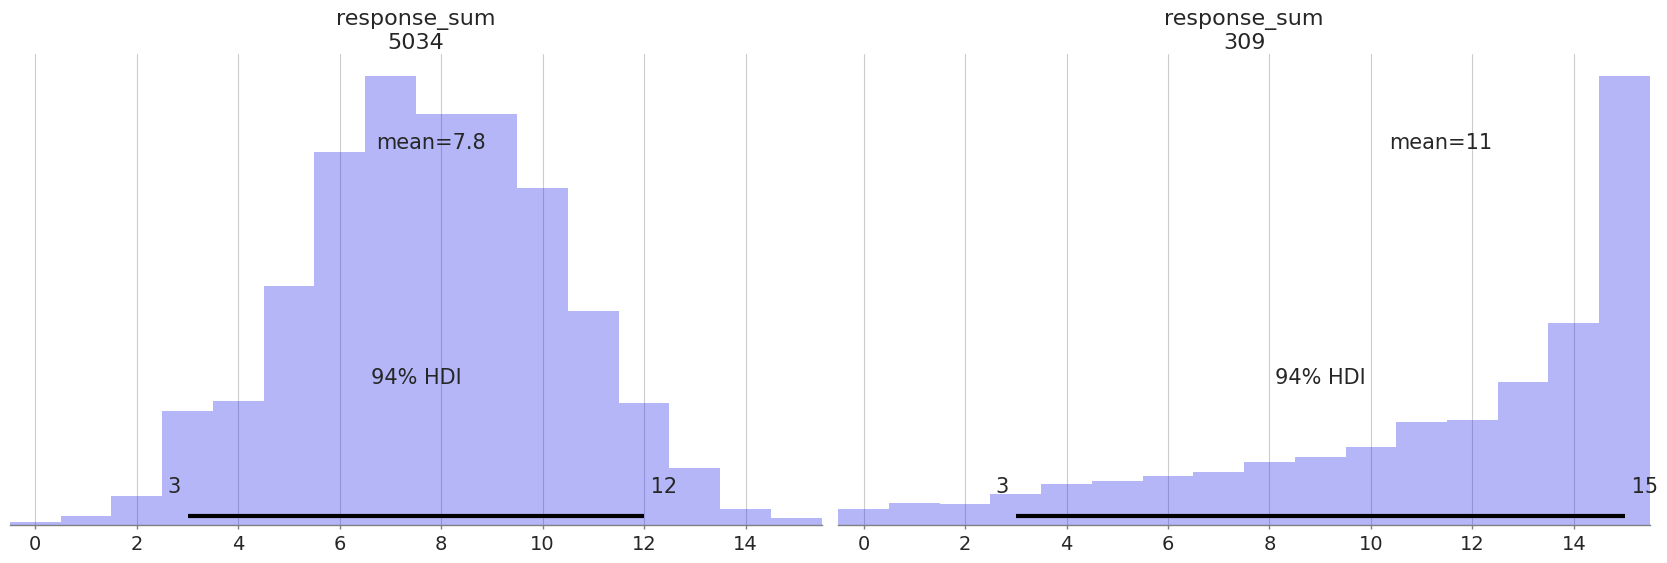

In [ ]:
az.plot_posterior(pp1.sel(respondent=list(REF_IDs)), group="predictions");

## Hierarchical regularization

The unpooled model can predict very extreme "conservatism" for respondents that only replied to a handful of questions.

It would make sense to use information about the "average" population bias, to inform our beliefs about the magnitude of bias for such respondents. We do this in the following model via the new `e_std` parameter

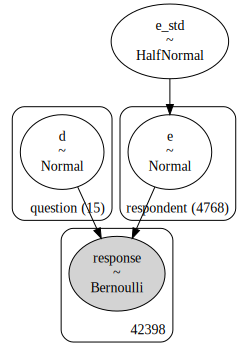

In [ ]:
coords = {
    "question": q_cat.categories,
    "respondent": id_cat.categories,
}
with pm.Model(coords=coords) as m2:
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))

    e_std = pm.HalfNormal("e_std", sigma=4)
    e = pm.Normal("e", mu=0, sigma=e_std, dims=("respondent",))

    logit_p = e[id_cat.codes] - d[q_cat.codes]

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        observed = long_q["answer"].values,
    )

m2.to_graphviz()

In [ ]:
with m2:
    idata2 = pm.sample(nuts_sampler="numpyro", random_seed=rng)
    az.to_netcdf(idata2, "idata2.nc")

Compiling...


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:655: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.892470
Sampling...


sample: 100%|██████████| 2000/2000 [00:58<00:00, 34.14it/s, 31 steps of size 1.54e-01. acc. prob=0.88]


Sampling time =  0:02:02.256126
Transforming variables...
Transformation time =  0:00:00.329615


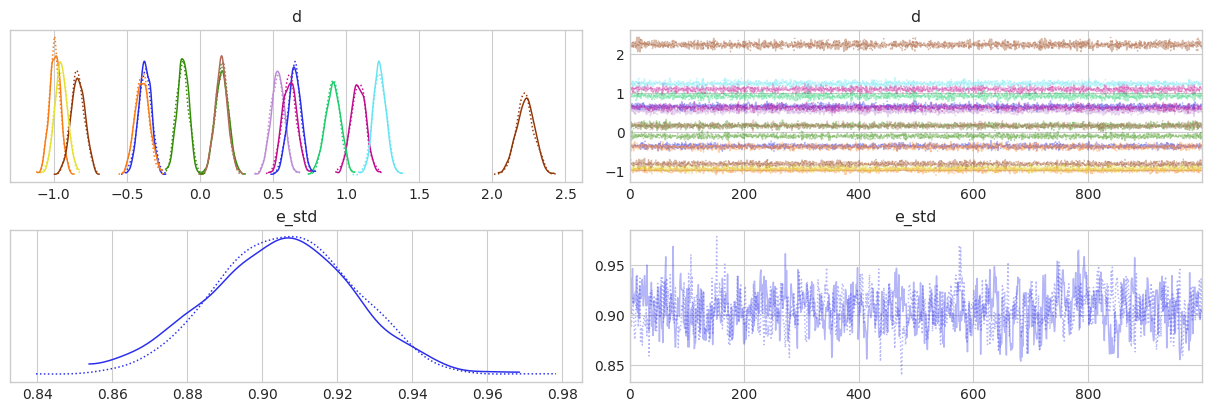

In [ ]:
az.plot_trace(idata2, var_names=["d", "e_std"]);

Notice the average `e_std` is around 0.9. That means new respondents (or respondents for which we have very little information), are unlikely to have a "conservative" bias that is higher than 0.9 * (2 standard devations) = 1.8 units. Contrast this with our original wide prior of 4 in the unpooled model.

As a consequence, many of the inferred "conservatism" levels are rather shrinked towards zero. The same happens to the inferred question "difficulties", although to a lesser extent

In [ ]:
def compare_models(*idata):
    d_means = idata[0].posterior["d"].mean(("chain", "draw"))
    sorted_q = idata[0].posterior["question"].sortby(-d_means)
    model_names = [f"m{i+1}" for i in range(len(idata))]
    az.plot_forest(
        idata,
        var_names=["d"],
        coords={"question": sorted_q},
        combined=True,
        model_names=model_names,
    )

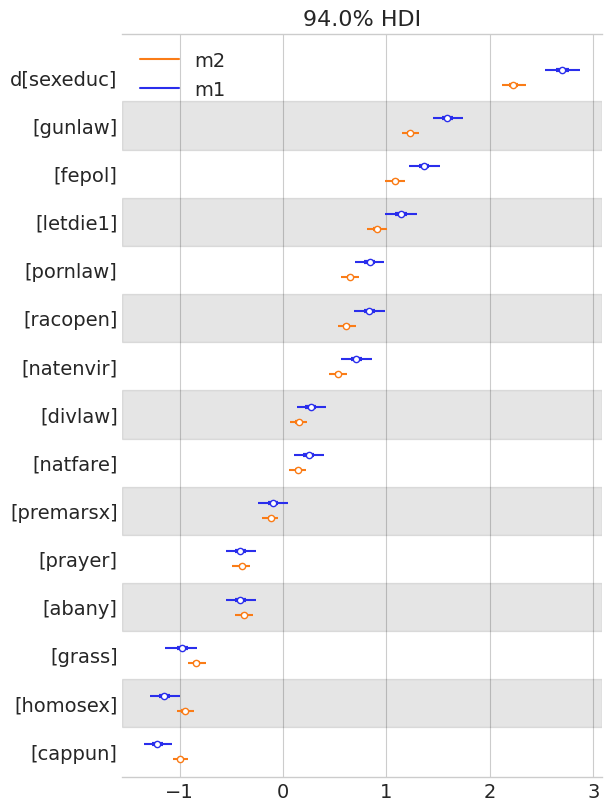

In [ ]:
compare_models(idata1, idata2)

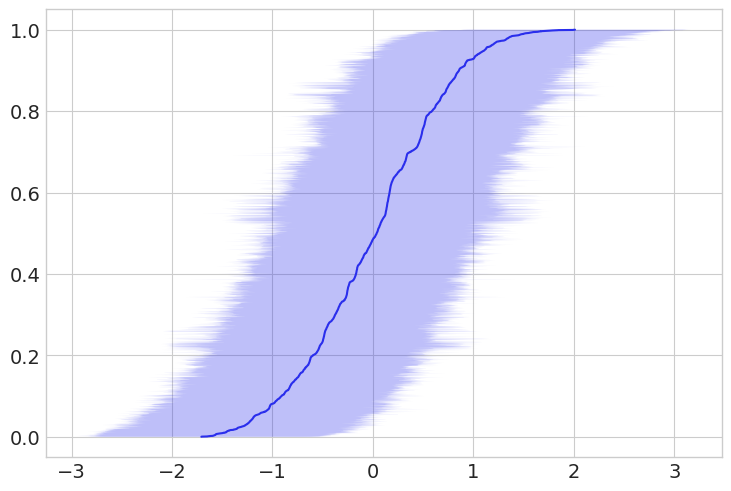

In [ ]:
mean_e = idata2.posterior["e"].mean(("chain", "draw"))
sorted_respondents = idata2.posterior["respondent"].sortby(mean_e)

y = np.linspace(0, 1, len(mean_e.respondent))
hdi = az.hdi(idata2.posterior["e"]).sortby(mean_e)
plt.plot(mean_e.sortby(mean_e), y)
plt.fill_betweenx(y, hdi["e"].values[:, 0], hdi["e"].values[:, 1], alpha=0.3);

### Posterior predictive

In [ ]:
with pm.Model(coords=coords):
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))
    e = pm.Normal("e", mu=0, sigma=4, dims=("respondent",))

    # Outer difference
    logit_p = e[:, None] - d

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        dims=("respondent", "question")
    )

    pm.Deterministic(
        "response_sum",
        response.sum(axis=-1),
        dims=("respondent"),
    )

    pp2 = pm.sample_posterior_predictive(
        idata2,
        var_names=["response_sum"],
        predictions=True,
        random_seed=rng,
    )

INFO:pymc.sampling.forward:Sampling: [response]


In [ ]:
mean_r = pp2.predictions["response_sum"].mean(("chain", "draw"))
sorted_respondents = idata2.posterior["respondent"].sortby(mean_e)

y = np.linspace(0, 1, len(mean_r.respondent))
hdi = az.hdi(pp2.predictions["response_sum"]).sortby(mean_r)
plt.plot(mean_r.sortby(mean_r), y)
plt.fill_betweenx(y, hdi["response_sum"].values[:, 0], hdi["response_sum"].values[:, 1], alpha=0.3);

### Single respondent

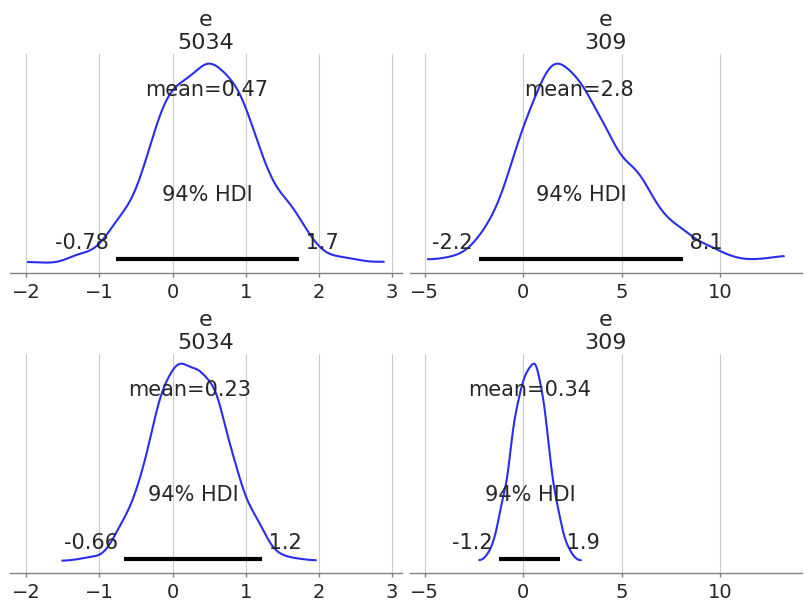

In [ ]:
_, ax = plt.subplots(2, 2, sharex="col", figsize=(8, 6))
az.plot_posterior(idata1.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[0]);
az.plot_posterior(idata2.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[1]);

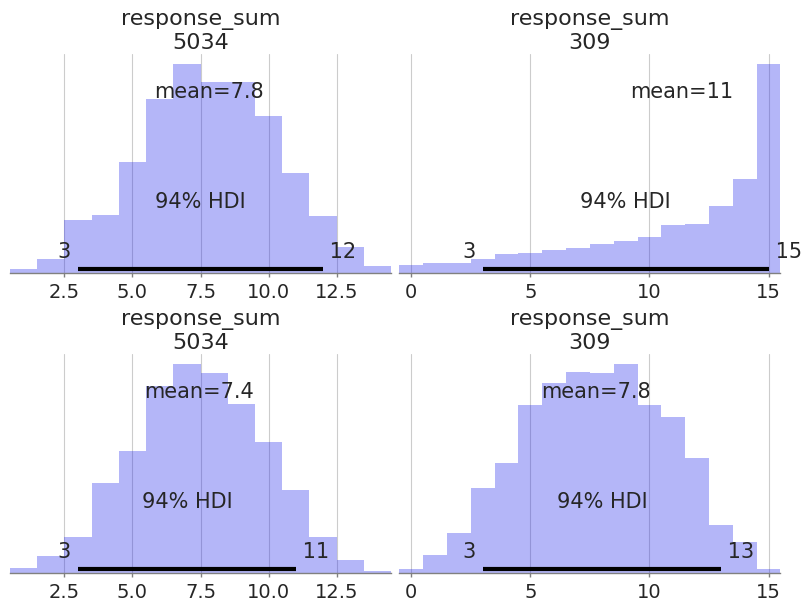

In [ ]:
_, ax = plt.subplots(2, 2, sharex="col", figsize=(8, 6))
az.plot_posterior(pp1.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[0]);
az.plot_posterior(pp2.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[1]);

In [ ]:
yes = questions["premarsx"] == True
no = questions["premarsx"] == False
all_responses = questions.loc[:, "homosex":"sexeduc"].mean(1)
print(all_responses[yes].mean(), all_responses[no].mean())
print(all_responses[yes].mean() * 15, all_responses[no].mean() * 15)

0.5766193310052197 0.296840167879242
8.649289965078296 4.45260251818863


## Conservatism Over Time

The following figure shows the average of these estimates for each years of the survey.

In [ ]:
years = q[q.iloc[:, :-2].isna().sum(1) > 0]["year"]
sorted_years = years[id_cat.categories]
r1_means = pp1.predictions["response_sum"].mean(("chain", "draw"))
r2_means = pp2.predictions["response_sum"].mean(("chain", "draw"))

<ipython-input-52-2c2ce4918669>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("year")["r1_mean", "r2_mean"].mean().plot();


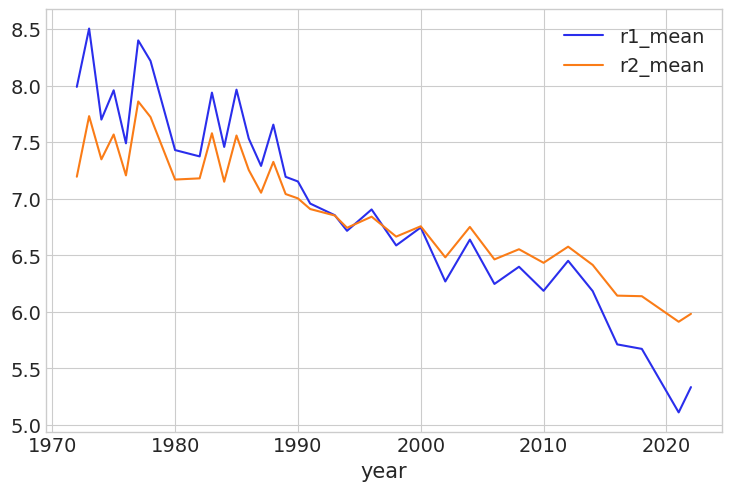

In [ ]:
df = pd.DataFrame()
df["year"] = sorted_years
df["r1_mean"] = r1_means
df["r2_mean"] = r2_means
df.groupby("year")["r1_mean", "r2_mean"].mean().plot();

The prevalence of conservative responses has decreased over the last 50 years.
In 1973, the average respondent chose a conservative response to 8.1 out of 15 questions; in 2021, it had fallen to 5.3.

There is no evidence that this trend has slowed or reversed recently.
In 2012 and 2014, it might have been above the long-term trend; in 2016 and 2018, it was below it.
And the most recent data, from 2021, is exactly on pace.

## Conservatism trend model

Let's try to model time trends directly

In [ ]:
q_year_cat = pd.Categorical(long_q["year"])
q_year_cat.categories, q_year_cat.codes

(Int64Index([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1980, 1982, 1983, 1984,
             1985, 1986, 1987, 1988, 1989, 1990, 1991, 1993, 1994, 1996, 1998,
             2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2021,
             2022],
            dtype='int64'),
 array([ 0,  0,  0, ..., 33, 33, 33], dtype=int8))

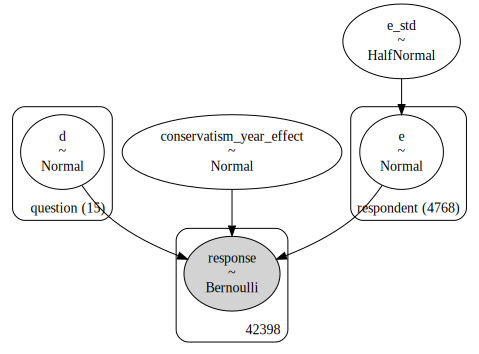

In [ ]:
coords = {
    "question": q_cat.categories,
    "respondent": id_cat.categories,
    "year": q_year_cat.categories,
}
with pm.Model(coords=coords) as m3:
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))

    e_std = pm.HalfNormal("e_std", sigma=4)
    e = pm.Normal("e", mu=0, sigma=e_std, dims=("respondent",))

    conservatism_year_effect = pm.Normal("conservatism_year_effect", mu=0, sigma=1)

    logit_p = (
        e[id_cat.codes]
        + conservatism_year_effect * q_year_cat.codes
        - d[q_cat.codes]
    )

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        observed = long_q["answer"].values,
    )

m3.to_graphviz()

In [ ]:
with m3:
    idata3 = pm.sample(nuts_sampler="numpyro", random_seed=rng)
    az.to_netcdf(idata3, "idata3.nc")

Compiling...


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:655: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.911331
Sampling...


sample: 100%|██████████| 2000/2000 [01:52<00:00, 17.82it/s, 31 steps of size 1.42e-01. acc. prob=0.88]


Sampling time =  0:03:48.534198
Transforming variables...
Transformation time =  0:00:00.351634


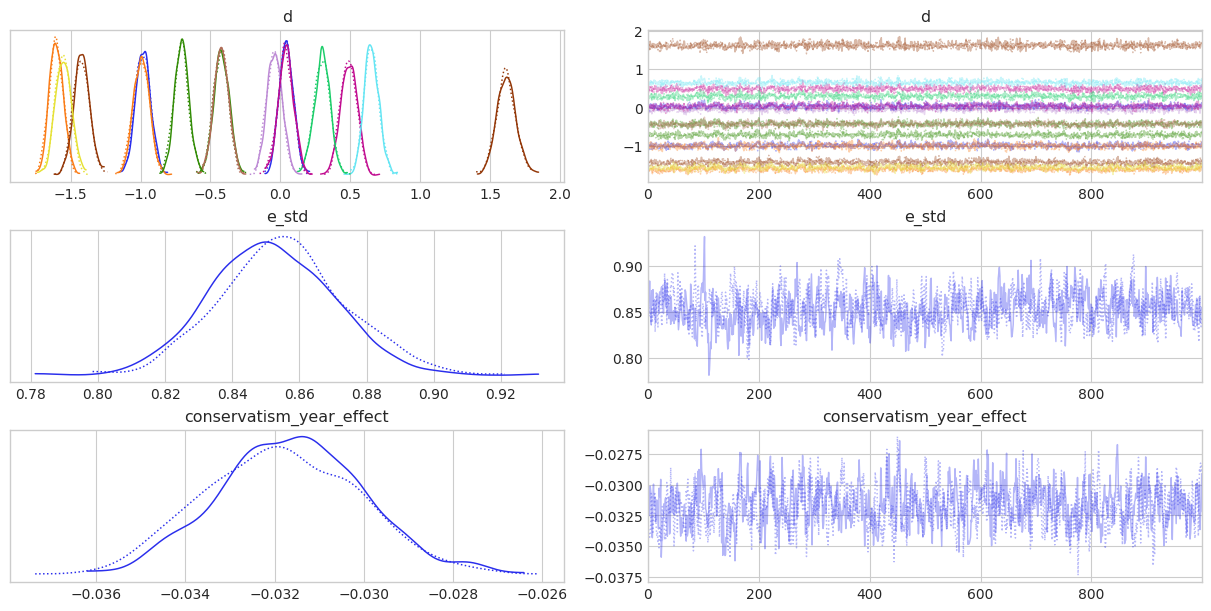

In [ ]:
az.plot_trace(idata3, var_names=["d", "e_std", "conservatism_year_effect"]);

For every measured year, there is a decrease of 0.03 logit units in conservative responses. Over the span of 30 measurement years, this translates to a quite substantial effect!

Note that by modelling the time effect, we can slightly reduces the expected individual variance in conservatism. In practice we are now modelling individual conservatism in reference to the first year of measurement.

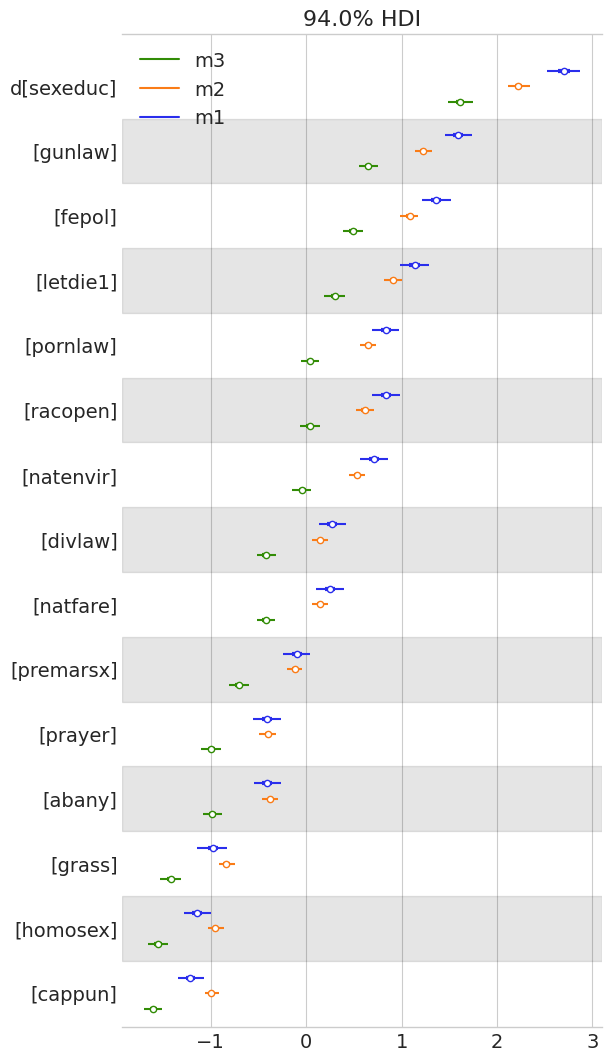

In [ ]:
compare_models(idata1, idata2, idata3)

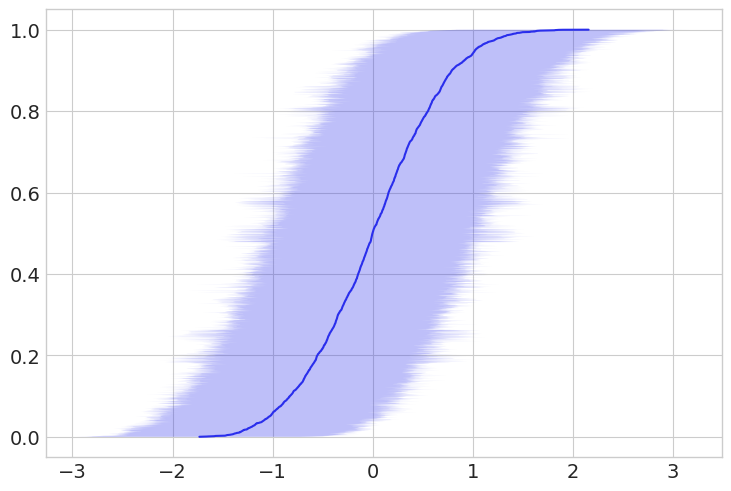

In [ ]:
mean_e = idata3.posterior["e"].mean(("chain", "draw"))
sorted_respondents = idata3.posterior["respondent"].sortby(mean_e)

y = np.linspace(0, 1, len(mean_e.respondent))
hdi = az.hdi(idata3.posterior["e"]).sortby(mean_e)
plt.plot(mean_e.sortby(mean_e), y)
plt.fill_betweenx(y, hdi["e"].values[:, 0], hdi["e"].values[:, 1], alpha=0.3);

### Posterior predictive

In [ ]:
years = q[q.iloc[:, :-2].isna().sum(1) > 0]["year"]
sorted_years = years[id_cat.categories]
sorted_years.groupby(sorted_years.index).min()

sorted_years_cat = pd.Categorical(sorted_years)
sorted_years_cat

[1972, 1972, 1972, 1972, 1972, ..., 2022, 2022, 2022, 2022, 2022]
Length: 4768
Categories (34, int64): [1972, 1973, 1974, 1975, ..., 2016, 2018, 2021, 2022]

In [ ]:
with pm.Model(coords=coords):
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))
    e = pm.Normal("e", mu=0, sigma=4, dims=("respondent",))
    conservatism_year_effect = pm.Normal("conservatism_year_effect", mu=0, sigma=1)

    # Outer difference
    logit_p = (
        (
            e
            + conservatism_year_effect * sorted_years_cat.codes
        )[:, None]
        - d
    )

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        dims=("respondent", "question")
    )

    pm.Deterministic(
        "response_sum",
        response.sum(axis=-1),
        dims=("respondent",),
    )

    pp3 = pm.sample_posterior_predictive(
        idata3,
        var_names=["response_sum"],
        predictions=True,
        random_seed=rng,
    )

INFO:pymc.sampling.forward:Sampling: [response]


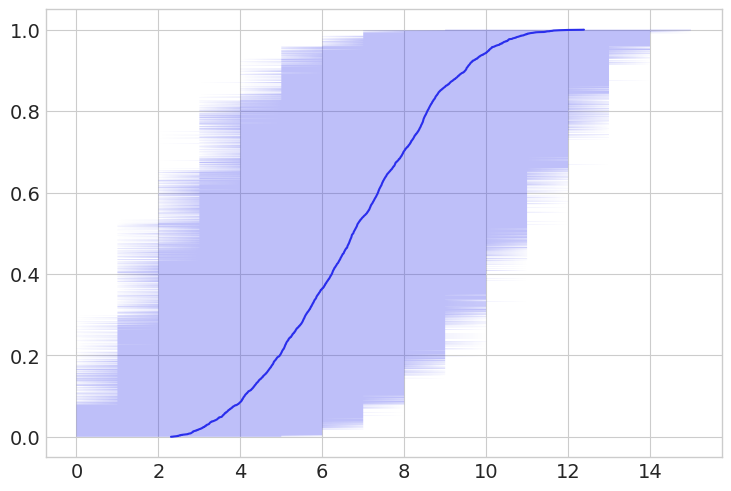

In [ ]:
mean_r = pp3.predictions["response_sum"].mean(("chain", "draw"))
sorted_respondents = idata3.posterior["respondent"].sortby(mean_e)

y = np.linspace(0, 1, len(mean_r.respondent))
hdi = az.hdi(pp3.predictions["response_sum"]).sortby(mean_r)
plt.plot(mean_r.sortby(mean_r), y)
plt.fill_betweenx(y, hdi["response_sum"].values[:, 0], hdi["response_sum"].values[:, 1], alpha=0.3);

In [ ]:
years = q[q.iloc[:, :-2].isna().sum(1) > 0]["year"]
sorted_years = years[id_cat.categories]
r1_means = pp1.predictions["response_sum"].mean(("chain", "draw"))
r2_means = pp2.predictions["response_sum"].mean(("chain", "draw"))
r3_means = pp3.predictions["response_sum"].mean(("chain", "draw"))

<ipython-input-63-674199f6e1ed>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("year")["r1_mean", "r2_mean", "r3_mean"].mean().plot();


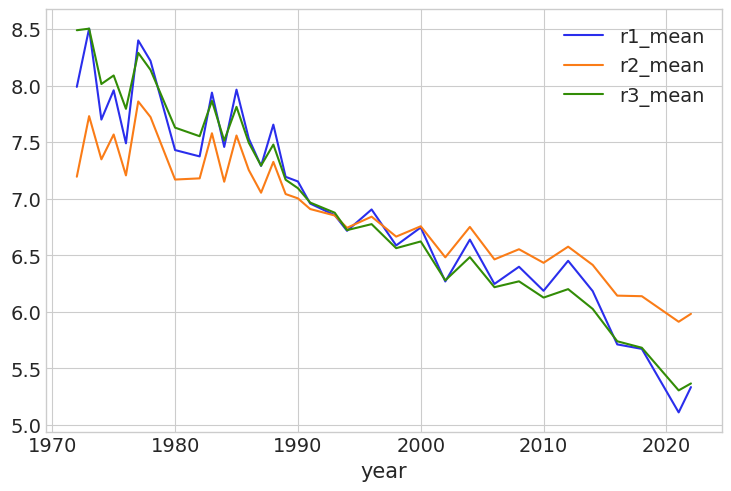

In [ ]:
df = pd.DataFrame()
df["year"] = sorted_years
df["r1_mean"] = r1_means
df["r2_mean"] = r2_means
df["r3_mean"] = r3_means
df.groupby("year")["r1_mean", "r2_mean", "r3_mean"].mean().plot();

### Single respondent

In [ ]:
q.query(f"id in {REF_IDs}")["year"].reset_index()

index  year
0   5034  1975
1    309  1972

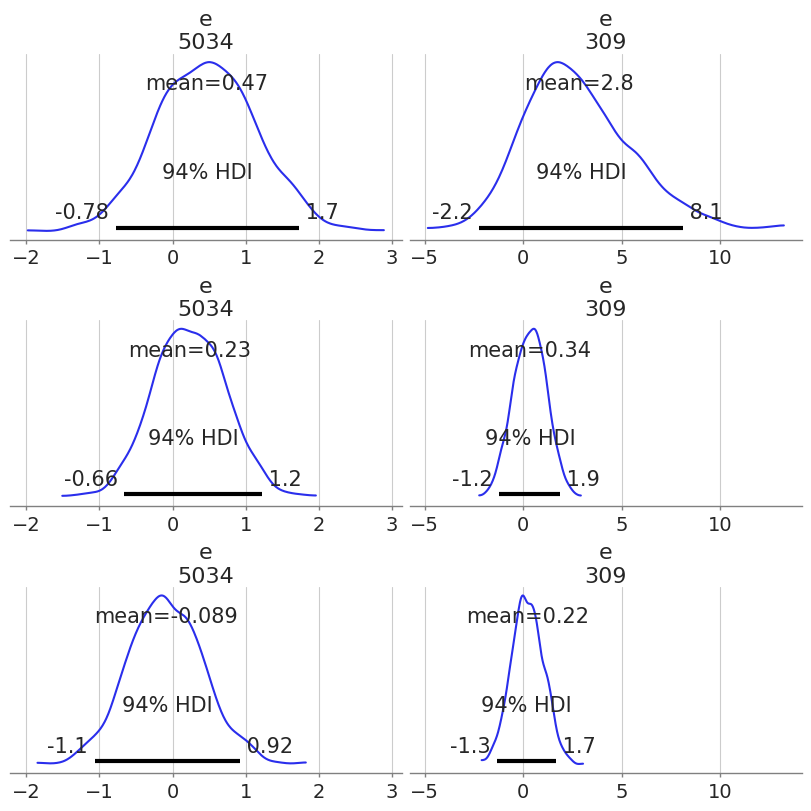

In [ ]:
_, ax = plt.subplots(3, 2, sharex="col", figsize=(8, 8))
az.plot_posterior(idata1.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[0]);
az.plot_posterior(idata2.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[1]);
az.plot_posterior(idata3.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[2]);

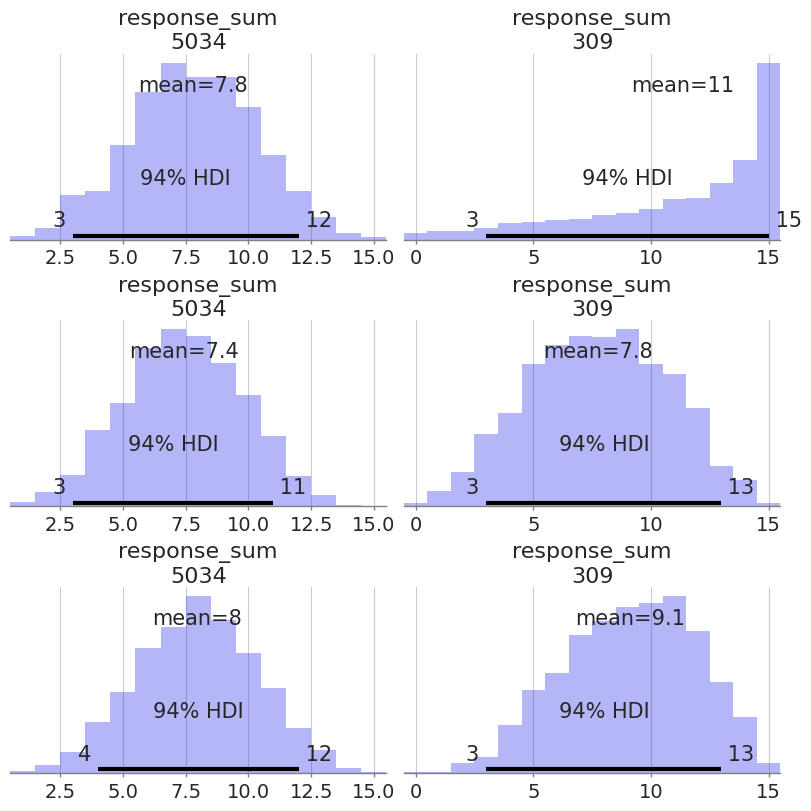

In [ ]:
_, ax = plt.subplots(3, 2, sharex="col", figsize=(8, 8))
az.plot_posterior(pp1.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[0]);
az.plot_posterior(pp2.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[1]);
az.plot_posterior(pp3.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[2]);

Interestingly, the third model imputes a relatively high number of conservative responses for the participant that gave a single response in 1972.

In [ ]:
long_q.query(f"id=={REF_IDs[1]}")

id  question  answer  year
29077  309  premarsx     1.0  1972

### New respondent

Now that we have a time effect, it may be interesting to check what would the model predict an unobserved participant would respond to every single question in every year that the questionnaire was performed.

In [ ]:
with pm.Model(coords=coords):
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))
    e_std = pm.HalfNormal("e_std", sigma=4)
    e_new = pm.Normal("e_new", mu=0, sigma=e_std)
    conservatism_year_effect = pm.Normal("conservatism_year_effect", mu=0, sigma=1)

    # Outer difference
    years = np.arange(len(q_year_cat.categories))
    logit_p = (
        e_new
        + (conservatism_year_effect * years)[:, None]
        - d
    )

    p = pm.Deterministic("p", pm.math.invlogit(logit_p), dims=("year", "question"))

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        dims=("year", "question")
    )

    pp32 = pm.sample_posterior_predictive(
        idata3,
        var_names=["e_new", "p", "response"],
        predictions=True,
        random_seed=rng,
    )

INFO:pymc.sampling.forward:Sampling: [e_new, response]


In [ ]:
def plot_questions_mean_prob(pp):
    years = pp.predictions["year"]
    p = pp.predictions["p"].mean("question")
    az.plot_hdi(
        x=years,
        y=p,
        hdi_prob=0.75,
        color=f"C0",
        smooth=False,
        fill_kwargs=dict(alpha=0.3),
    )
    plt.plot(years, p.mean(("chain", "draw")), color="black", ls="--", alpha=0.7)
    plt.title("Probability of conservative answer (75% HDI)")

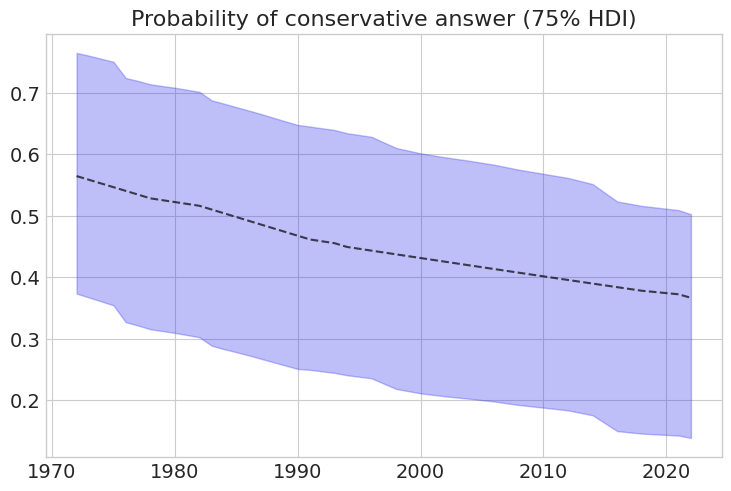

In [ ]:
plot_questions_mean_prob(pp32)

In [ ]:
def plot_questions_prob(pp):
    p_means = pp.predictions["p"].mean(("chain", "draw", "year"))
    sorted_p = pp.predictions["question"].sortby(-p_means)

    fig, ax = plt.subplots(3, 5, figsize=(12, 8), sharex=True, sharey=True)
    years = pp.predictions["year"]
    for qi, axi in enumerate(ax.ravel()):
        q_label = sorted_p[qi].values.item()
        axi.set_title(q_label)

        color = f"C{qi}"
        p = pp.predictions["p"].sel(question=q_label)
        az.plot_hdi(
            x=years,
            y=p,
            hdi_prob=0.75,
            color=color,
            smooth=False,
            fill_kwargs=dict(alpha=0.3),
            ax=axi
        )
        axi.plot(years, p.mean(("chain", "draw")), color="black", ls="--", alpha=0.7)
    fig.suptitle("Probability of conservative answer (75% HDI)", fontsize=16)

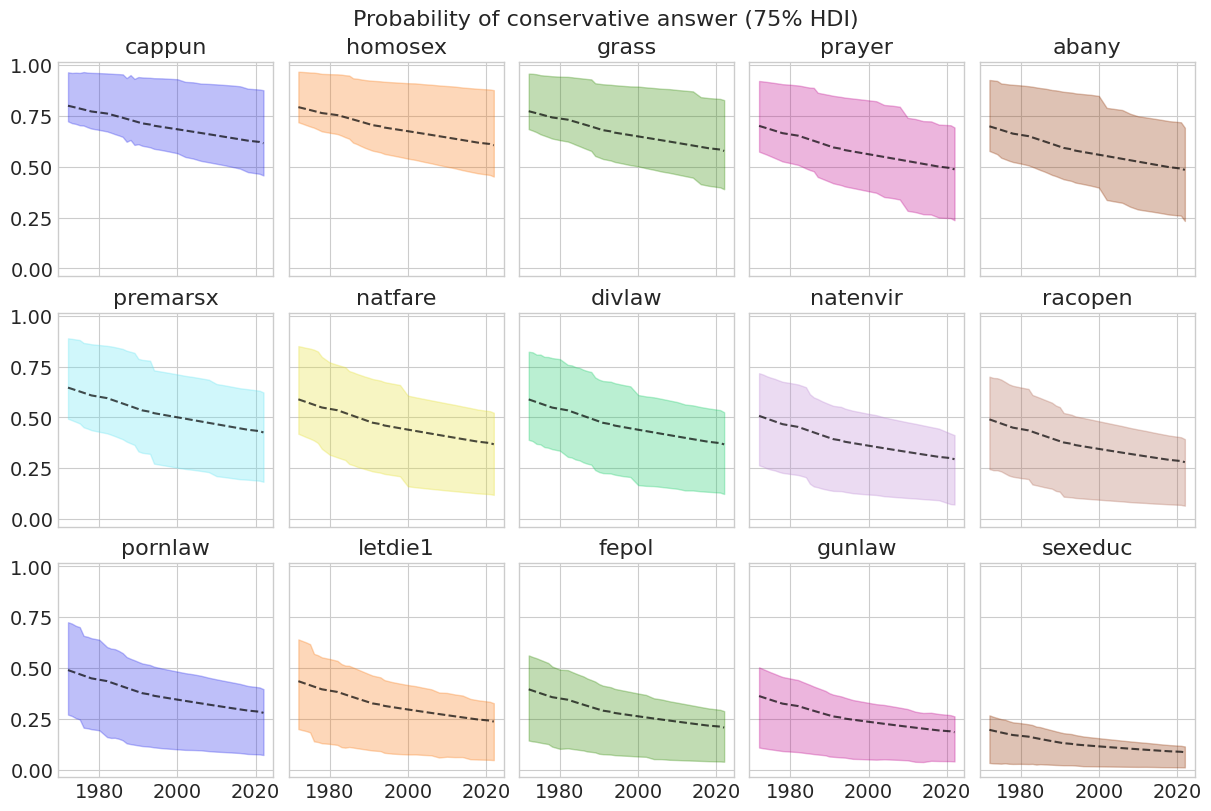

In [ ]:
plot_questions_prob(pp32)

## Polarization trend model

In [ ]:
id_year_cat = pd.Categorical(long_q.groupby("id")["year"].first())
id_year_cat.categories, id_year_cat.codes

(Int64Index([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1980, 1982, 1983, 1984,
             1985, 1986, 1987, 1988, 1989, 1990, 1991, 1993, 1994, 1996, 1998,
             2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2021,
             2022],
            dtype='int64'),
 array([ 0,  0,  0, ..., 33, 33, 33], dtype=int8))

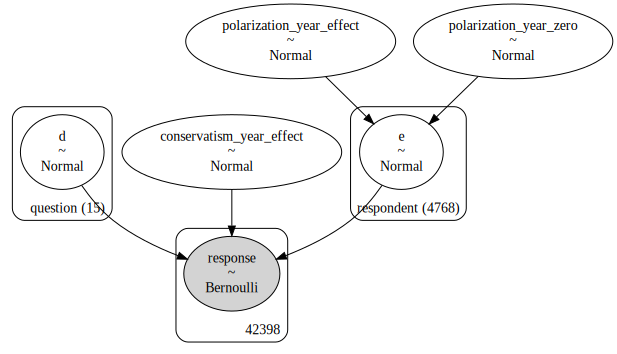

In [ ]:
coords = {
    "question": q_cat.categories,
    "respondent": id_cat.categories,
    "year": q_year_cat.categories,
}
with pm.Model(coords=coords) as m4:
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))

    polarization_year_zero = pm.Normal("polarization_year_zero")
    polarization_year_effect = pm.Normal("polarization_year_effect")
    e_std = pm.math.exp(
        polarization_year_zero
        + polarization_year_effect * id_year_cat.codes
    )
    e = pm.Normal("e", mu=0, sigma=e_std, dims=("respondent",))

    conservatism_year_effect = pm.Normal("conservatism_year_effect", mu=0, sigma=1)

    logit_p = (
        e[id_cat.codes]
        + conservatism_year_effect * q_year_cat.codes
        - d[q_cat.codes]
    )

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        observed = long_q["answer"].values,
    )

m4.to_graphviz()

In [ ]:
with m4:
    idata4 = pm.sample(nuts_sampler="numpyro", random_seed=rng)
    az.to_netcdf(idata4, "idata4.nc")

Compiling...


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:655: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.975186
Sampling...


sample: 100%|██████████| 2000/2000 [02:39<00:00, 12.56it/s, 63 steps of size 9.54e-02. acc. prob=0.92]


Sampling time =  0:04:49.656367
Transforming variables...
Transformation time =  0:00:00.347682


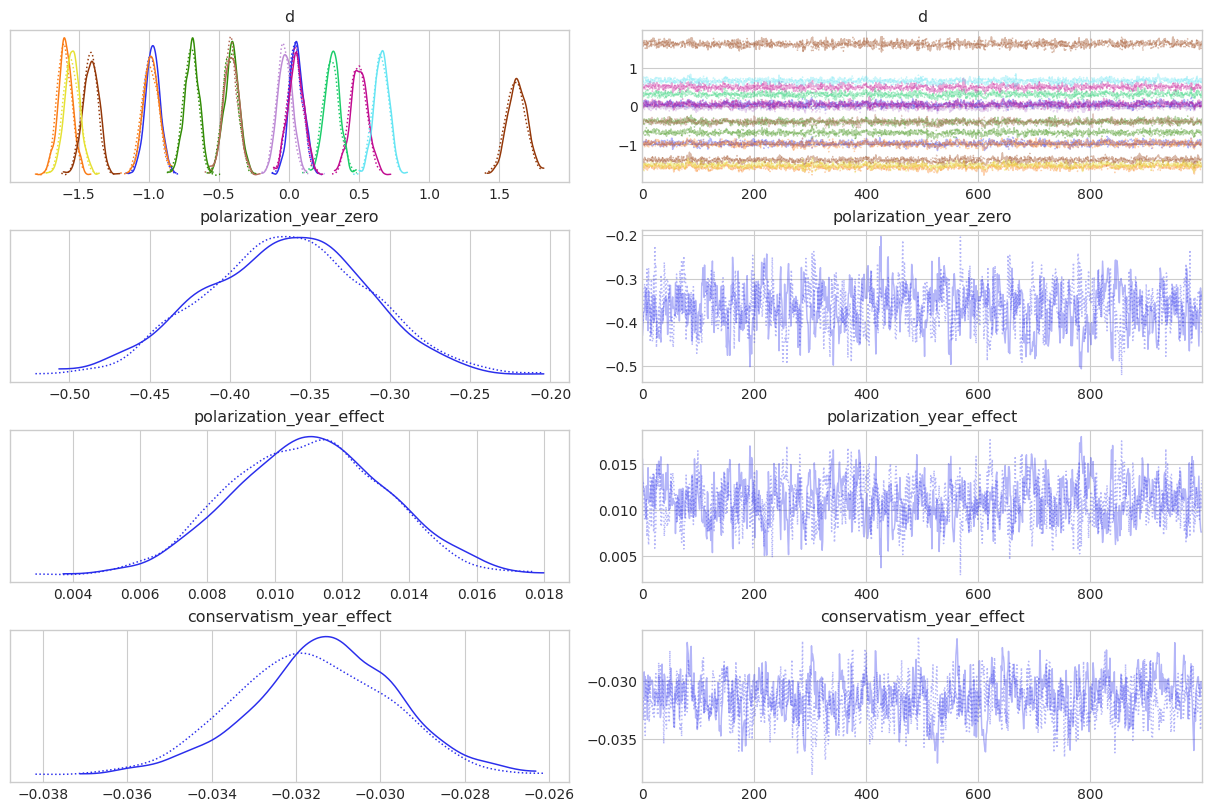

In [ ]:
az.plot_trace(idata4, var_names=["d", "polarization_year_zero", "polarization_year_effect", "conservatism_year_effect"]);

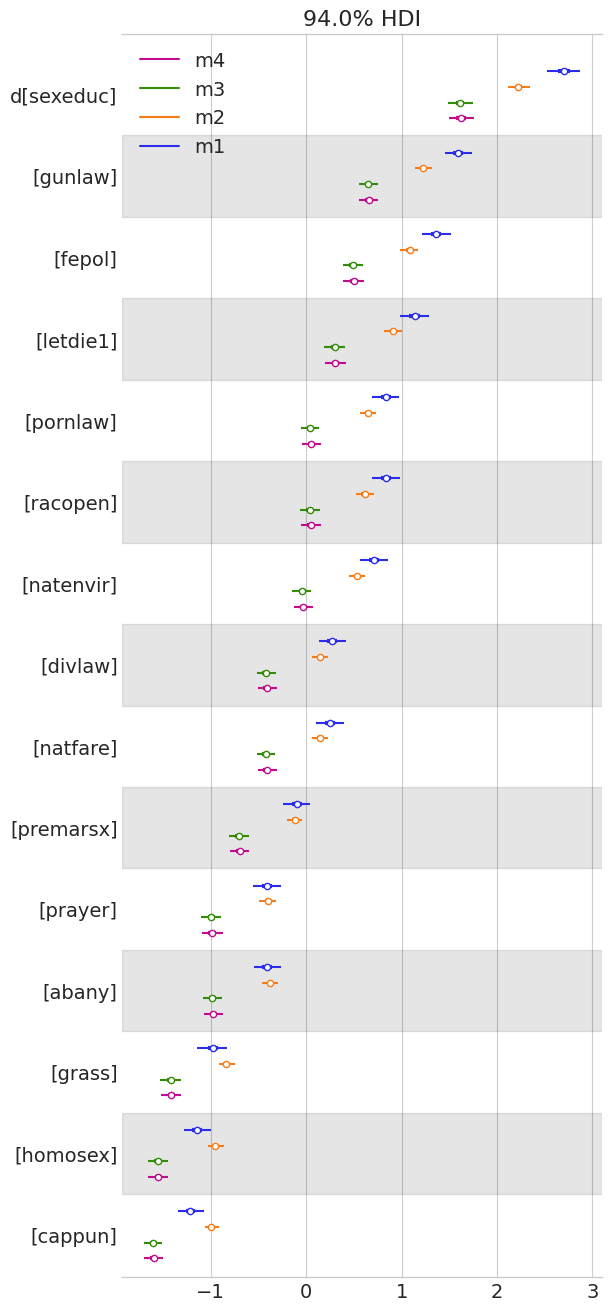

In [ ]:
compare_models(idata1, idata2, idata3, idata4)

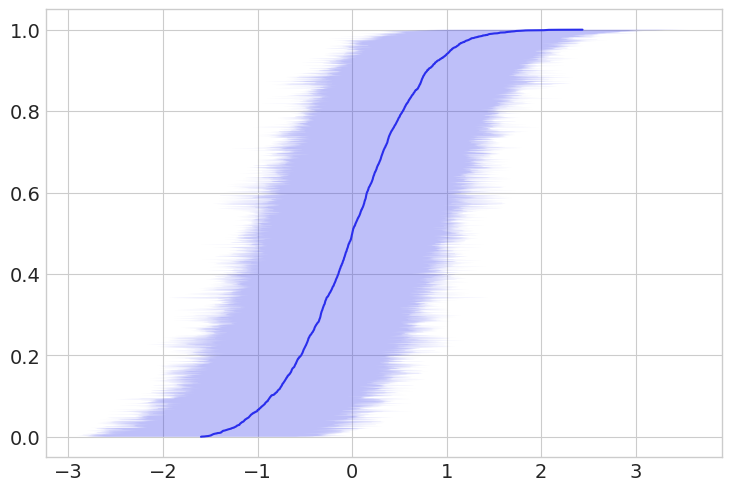

In [ ]:
mean_e = idata4.posterior["e"].mean(("chain", "draw"))
sorted_respondents = idata4.posterior["respondent"].sortby(mean_e)

y = np.linspace(0, 1, len(mean_e.respondent))
hdi = az.hdi(idata4.posterior["e"]).sortby(mean_e)
plt.plot(mean_e.sortby(mean_e), y)
plt.fill_betweenx(y, hdi["e"].values[:, 0], hdi["e"].values[:, 1], alpha=0.3);

### Posterior predictive

In [ ]:
with pm.Model(coords=coords):
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))
    e = pm.Normal("e", mu=0, sigma=1, dims=("respondent",))  # Will be taken from the trace
    conservatism_year_effect = pm.Normal("conservatism_year_effect", mu=0, sigma=1)

    # Outer difference
    logit_p = (
        (
            e
            + conservatism_year_effect * sorted_years_cat.codes
        )[:, None]
        - d
    )

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        dims=("respondent", "question")
    )

    pm.Deterministic(
        "response_sum",
        response.sum(axis=-1),
        dims=("respondent",),
    )

    pp4 = pm.sample_posterior_predictive(
        idata4,
        var_names=["response_sum"],
        predictions=True,
        random_seed=rng,
    )

INFO:pymc.sampling.forward:Sampling: [response]


### Single respondent

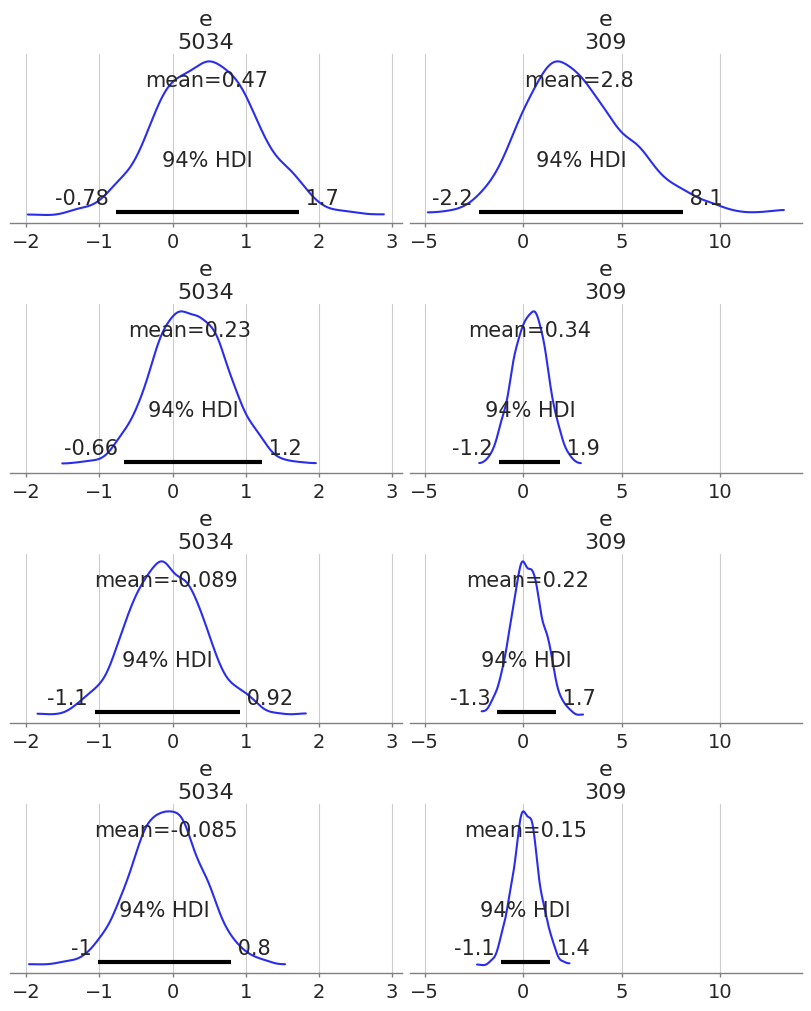

In [ ]:
_, ax = plt.subplots(4, 2, sharex="col", figsize=(8, 10))
az.plot_posterior(idata1.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[0]);
az.plot_posterior(idata2.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[1]);
az.plot_posterior(idata3.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[2]);
az.plot_posterior(idata4.posterior.sel(respondent=list(REF_IDs)), var_names=["e"], ax=ax[3]);

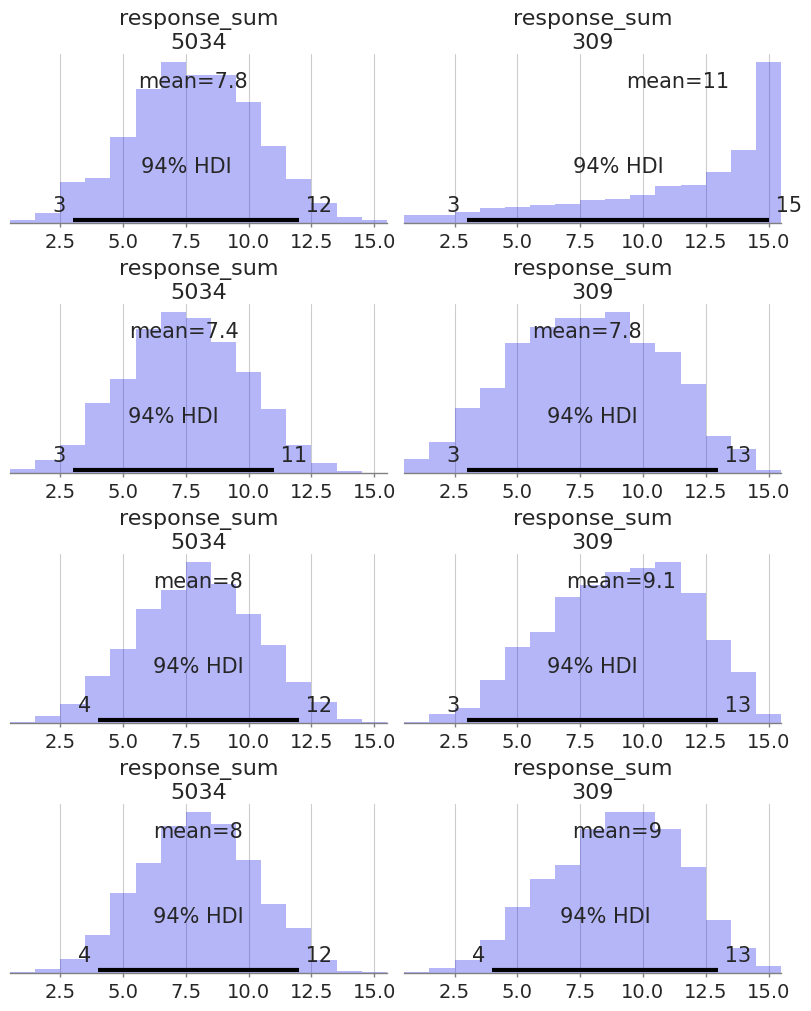

In [ ]:
_, ax = plt.subplots(4, 2, sharex="col", figsize=(8, 10))
az.plot_posterior(pp1.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[0]);
az.plot_posterior(pp2.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[1]);
az.plot_posterior(pp3.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[2]);
az.plot_posterior(pp4.sel(respondent=list(REF_IDs)), group="predictions", ax=ax[3]);

### New respondent

In [ ]:
with pm.Model(coords=coords):
    d = pm.Normal("d", mu=0, sigma=1, dims=("question",))

    polarization_year_zero = pm.Normal("polarization_year_zero")
    polarization_year_effect = pm.Normal("polarization_year_effect")
    id_years = np.arange(len(id_year_cat.categories))
    e_std = pm.math.exp(
        polarization_year_zero
        + polarization_year_effect * id_years
    )
    e_new = pm.Normal("e_new", mu=0, sigma=e_std, dims=("year",))

    conservatism_year_effect = pm.Normal("conservatism_year_effect", mu=0, sigma=1)

    # Outer difference
    q_years = np.arange(len(q_year_cat.categories))
    logit_p = (
        (
            e_new
            + conservatism_year_effect * q_years)
        [:, None]
        - d
    )

    p = pm.Deterministic("p", pm.math.invlogit(logit_p), dims=("year", "question"))

    response = pm.Bernoulli(
        "response",
        logit_p=logit_p,
        dims=("year", "question")
    )

    pp42 = pm.sample_posterior_predictive(
        idata4,
        var_names=["e_new", "p", "response"],
        predictions=True,
        random_seed=rng,
    )

INFO:pymc.sampling.forward:Sampling: [e_new, response]


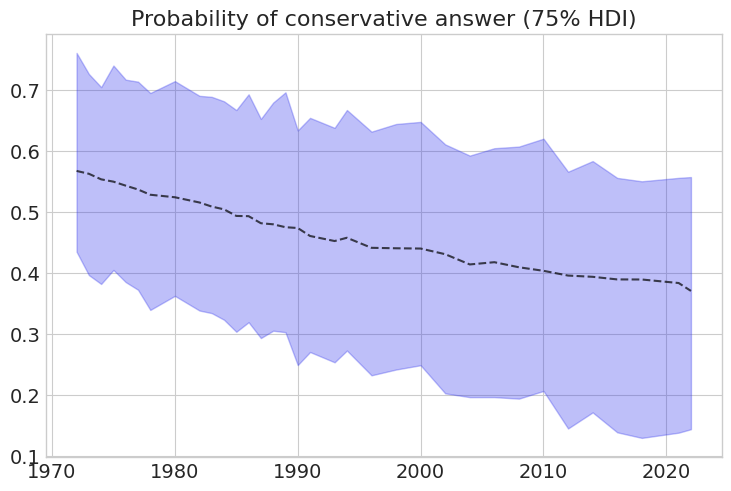

In [ ]:
plot_questions_mean_prob(pp42)

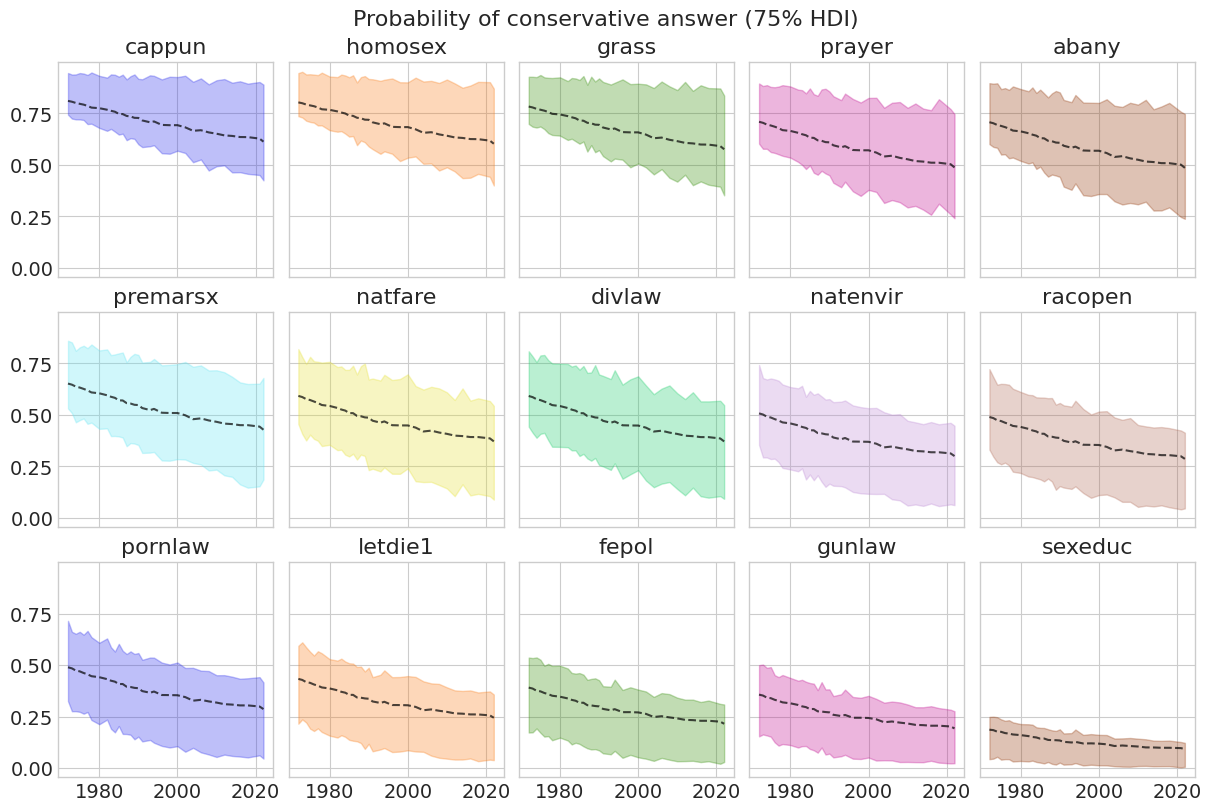

In [ ]:
plot_questions_prob(pp42)